<a href="https://colab.research.google.com/github/fady-louis/Face_Positions/blob/main/Face_Positions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Made by :- eng.Fady Maged Louis <br>
Supervised by :- eng.Mohamed Hussien  <br>
All Thanks To eng.Marwan Abdelsalam

Installing mediapipe library to get points of the face

In [1]:


%%capture
!pip install mediapipe



import all needed library

In [15]:


import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow
from sklearn.model_selection import cross_val_score,GridSearchCV
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error


Get all ALFW2000 images and mat files

In [3]:
%%capture
if os.path.isfile('/content/AFLW2000-3D.zip') == False:
  !gdown --id  1fP3zvSCYjll_o_m7S12nvQLZ9MnsEoap
  !unzip /content/AFLW2000-3D.zip

function that will be used to draw axis

In [4]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

Make all .jpg in list

In [5]:
import glob, os
os.chdir("/content/AFLW2000/")
list_of_imgs=[]
for file in glob.glob("*.jpg"):
    list_of_imgs.append(file)
print(list_of_imgs)

['image00972.jpg', 'image04180.jpg', 'image01086.jpg', 'image00334.jpg', 'image03075.jpg', 'image00862.jpg', 'image03026.jpg', 'image00527.jpg', 'image00726.jpg', 'image00960.jpg', 'image01469.jpg', 'image00545.jpg', 'image02592.jpg', 'image00122.jpg', 'image01163.jpg', 'image03926.jpg', 'image00082.jpg', 'image03892.jpg', 'image02295.jpg', 'image03453.jpg', 'image02073.jpg', 'image02030.jpg', 'image01773.jpg', 'image00329.jpg', 'image02080.jpg', 'image01472.jpg', 'image02332.jpg', 'image01785.jpg', 'image02038.jpg', 'image02544.jpg', 'image03835.jpg', 'image02054.jpg', 'image03624.jpg', 'image00036.jpg', 'image02034.jpg', 'image01329.jpg', 'image03791.jpg', 'image03984.jpg', 'image01087.jpg', 'image02769.jpg', 'image00734.jpg', 'image03908.jpg', 'image03765.jpg', 'image00360.jpg', 'image02739.jpg', 'image02513.jpg', 'image03270.jpg', 'image04062.jpg', 'image03977.jpg', 'image01346.jpg', 'image00294.jpg', 'image03013.jpg', 'image01762.jpg', 'image00753.jpg', 'image00826.jpg', 'image028

Get points & angles from AFLW2000 dataset

In [6]:
X_points = []
Y_points = []
labels = []
detected_files = []
faceModule = mediapipe.solutions.face_mesh
# looping over the file names to load the images and their corresponding mat file
for filename in list_of_imgs:
  filename= filename.replace(".jpg", "")
  with faceModule.FaceMesh(static_image_mode=True) as faces:
    
    # loading the image
    image = cv2.imread('/content/AFLW2000/'+filename+'.jpg')
    # processing the image to detect the face and then generating the land marks (468 for each x,y,z).
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None: 
          # appending the file names where have been detected.
          detected_files.append(filename)
          # detecting the face
          face = results.multi_face_landmarks[0]
          # initializing two lists to store the points for the image.
          X = []
          Y = []
          # looping over the 468 points of x and y
          for landmark in face.landmark:
              x = landmark.x
              y = landmark.y
              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image.
              shape = image.shape 
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])
              # X_features
              X.append(relative_x)
              # Y_features
              Y.append(relative_y)

          # converting the lists to numpy arrays
          X = np.array(X)
          Y = np.array(Y)
          # appending the points of the images in the list of all image points
          X_points.append(X)
          Y_points.append(Y)

          # loading the mat file to extract the labels (pitch,yaw,roll)
          mat_file = sio.loadmat('/content/AFLW2000/'+filename+'.mat')
          # extracting the labels 3 angels
          pose_para = mat_file["Pose_Para"][0][:3]
          # appending the 3 angels to labels list
          labels.append(pose_para)

# converting features and labels to 2D array
X_points = np.array(X_points)
Y_points = np.array(Y_points)
labels = np.array(labels)

# the first label (pitch)
pitch_label = labels[:,0]
# the first label (yaw)
yaw_label = labels[:,1]
# the first label (roll)
roll_label = labels[:,2]
print(X_points.shape)
print(Y_points.shape)
print(labels.shape)
print(X_points)
print(Y_points)
print(labels)

(1853, 468)
(1853, 468)
(1853, 3)
[[223 220 222 ... 237 291 295]
 [208 189 207 ... 225 280 286]
 [231 228 229 ... 239 295 299]
 ...
 [230 245 234 ... 244 269 272]
 [194 199 202 ... 241 287 294]
 [255 260 252 ... 251 289 293]]
[[304 272 283 ... 223 211 208]
 [316 291 296 ... 230 214 205]
 [315 291 296 ... 221 197 193]
 ...
 [298 281 284 ... 235 224 220]
 [281 254 266 ... 229 240 238]
 [284 248 265 ... 217 216 212]]
[[ 0.075391    0.06628842 -0.07607973]
 [-0.51412052  0.75234222 -0.34148681]
 [-0.34731895 -0.02775929 -0.09128705]
 ...
 [-0.53795624 -0.47879195  0.25495899]
 [ 0.28218687  0.60487312  0.47403568]
 [ 0.38623983 -0.32851034 -0.10940092]]


edit points to be sure the points will be in the half of the face 
even if the face in the corner of the photo

In [9]:
#get distance between points and middle of the face "point number 99"
#note: point 99 is the point in the middle of the face  "nose"
Center_X = X_points - X_points[:,99].reshape(-1,1)
Center_Y = Y_points - Y_points[:,99].reshape(-1,1)

# normalizing the data to be in the same scale by dividing over the distance between point 10 and point 171
#Note :- Point 10,point 171 are first and last point in the face because of that we choose them to calculate distance
X_171 = X_points[:,171]
X_10 = X_points[:,10]
Y_171 = Y_points[:,171]
Y_10 = Y_points[:,10]
# computing the distance
distance = np.linalg.norm(np.array((X_10,Y_10)) - np.array((X_171,Y_171)),axis = 0).reshape(-1,1)
Norm_X = Center_X / distance
Norm_Y = Center_Y / distance

# if you want to choose specific columns from the data
Final_X = Norm_X
Final_Y = Norm_Y

# concatinating the X and Y points to form the compelete features
features = np.hstack([Final_X,Final_Y])

After trying XGboost and Rondom_forest I'll use SVR
because SVR give both average speed and good accuracy

first lets split data 20:80

In [10]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val,file_train,file_test = train_test_split(features,labels,detected_files,test_size = 0.2,random_state = 20)
y_train_pitch = y_train[:,0]
y_train_yaw = y_train[:,1]
y_train_roll = y_train[:,2]
y_val_pitch = y_val[:,0]
y_val_yaw = y_val[:,1]
y_val_roll = y_val[:,2]

Make Grid Search for SVR to get best parameter --> Kernel,C

In [17]:


parmeters = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'],'C':[0.01,0.1,1,10,100]}
# grid search pitch
svr = SVR()
svr_gs_pitch = GridSearchCV(estimator = svr,param_grid = parmeters)
svr_gs_pitch.fit(X_train, y_train_pitch)
svr_winner_pitch = svr_gs_pitch.best_estimator_
print("Pitch Winner Model: ",svr_winner_pitch)
print("Train Error: ",mean_absolute_percentage_error(svr_winner_pitch.predict(X_train),y_train_pitch))

print("Validation Error: ",mean_absolute_percentage_error(svr_winner_pitch.predict(X_val),y_val_pitch))


# grid search yaw
svr = SVR()
svr_gs_yaw = GridSearchCV(estimator = svr,param_grid = parmeters)
svr_gs_yaw.fit(X_train, y_train_yaw)
svr_winner_yaw = svr_gs_yaw.best_estimator_
print("Yaw Winner Model: ",svr_winner_yaw)
print("Train Error: ",mean_absolute_percentage_error(svr_winner_yaw.predict(X_train),y_train_yaw))
print("Validation Error: ",mean_absolute_percentage_error(svr_winner_yaw.predict(X_val),y_val_yaw))

# grid search roll
svr = SVR()
svr_gs_roll = GridSearchCV(estimator = svr,param_grid = parmeters)
svr_gs_roll.fit(X_train, y_train_roll)
svr_winner_roll = svr_gs_roll.best_estimator_
print("Yaw Winner Model: ",svr_winner_roll)
print("Train Error: ",mean_absolute_percentage_error(svr_winner_roll.predict(X_train),y_train_roll))
print("Validation Error: ",mean_absolute_percentage_error(svr_winner_roll.predict(X_val),y_val_roll))

Pitch Winner Model:  SVR(C=10, kernel='poly')
Train Error:  3.67394437068746
Validation Error:  1.3734482153965542
Yaw Winner Model:  SVR(C=10, kernel='linear')
Train Error:  1.4815972879173558
Validation Error:  1.3899904658784459
Yaw Winner Model:  SVR(C=100)
Train Error:  10.416972020115354
Validation Error:  1.4354916961659023


In [18]:


def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img



Testing for image03821 in data set

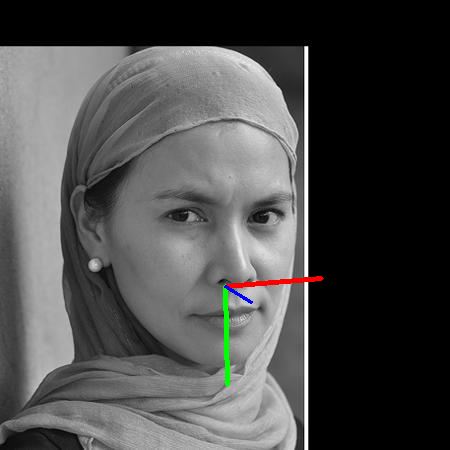

In [23]:

image_name = 'image03821'
faceModule = mediapipe.solutions.face_mesh
with faceModule.FaceMesh(static_image_mode=True) as face:
  frame = cv2.imread('/content/AFLW2000/' + image_name + '.jpg')
  results = face.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
  if results.multi_face_landmarks != None:
    for face in results.multi_face_landmarks:
        # initializing two lists that will store all data set
        X_List = []
        Y_List = []
        for j,landmark in enumerate(face.landmark):
            x = landmark.x
            y = landmark.y
            shape = frame.shape 
            relative_x = int(x * shape[1])
            relative_y = int(y * shape[0])
            # appending the points to the X_List and Y_List lists
            X_List.append(relative_x)
            Y_List.append(relative_y)


        #Make Y_List and X_List that contain all data set
        X_List = np.array(X)
        Y_List = np.array(Y)


        #edit points to be sure the points will be in the half of the face even if the face in the corner of the photo
        X_center = X_List - X_List[99]
        Y_center = Y_List - Y_List[99]
        # computing the distance between the point 171 and 10 
        # Note:- points 10 and 171 is first and last points in the face
        d = np.linalg.norm(np.array((X_List[171],Y_List[171])) - np.array((X_List[10],Y_List[10])))
        X_norm = X_center/d
        Y_norm = Y_center/d
        X_norm = X_norm
        Y_norm = Y_norm
        # concatinating the x and y points to predict the labels (pitch,yaw,roll)
        points = np.hstack([X_norm,Y_norm]).reshape(1,-1)
        # predicting the 3 angels to draw the axis on the image
        pred_pitch = svr_winner_pitch.predict(points)
        pred_yaw = svr_winner_yaw.predict(points)
        pred_roll = svr_winner_roll.predict(points)
        cv2_imshow(draw_axis(frame,pred_pitch,pred_yaw,pred_roll,X[99],Y[99]))

open git hub repo to import video

In [22]:
%%capture
!git clone https://github.com/fady-louis/Face_Positions

we will use Queue to get average of frames in the video
to make the video more realistic

In [24]:
class Queue:
    # defining the constructor
    def __init__(self,max_size):
        self.queue = []
        self.length = 0
        self.max_size = max_size
    
    # adding values to the queue
    def enqueue(self,x):
        if self.length < self.max_size:
          self.queue.append(x)
          self.length = self.length+1
        else:
          print("You have reached the maximum size") 
    # removing values from the queue
    def dequeue(self):
        if len(self.queue) > 0:
            removed = self.queue[0]
            del self.queue[0]
            self.length = self.length-1
            return removed
        else:
            print("Queue is Empty")

    # checking if the queue is full
    def IsFull(self):
      if self.length == self.max_size:
        return True
    
    # printing the queue values
    def print_queue(self):
        for i in self.queue:
            print(i)

In [51]:
# Create a VideoCapture object and read from input file
def Create_TestVideo(pitch_model,yaw_model,roll_model,smoothing = False,size = 20):

  cap = cv2.VideoCapture('/content/AFLW2000/Face_Positions/try.mp4')
  width= int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  height= int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

  # Check if camera opened successfully
  if (cap.isOpened()== False): 
      print("Error opening video file")

  
  pitch_queue = Queue(max_size = size)
  yaw_queue = Queue(max_size = size)
  roll_queue = Queue(max_size = size)

  # initializing a list to store the frames   
  img_array = []
  # Read until video is completed
  while(cap.isOpened()):   
    # Capture frame-by-frame
      ret, frame = cap.read()
      if ret == True:
        with faceModule.FaceMesh(static_image_mode=True) as face:
          # processing the image to detect the face and then generating the land marks (468 for each x,y,z).
          results = face.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
          if results.multi_face_landmarks != None:
            for face in results.multi_face_landmarks:
                # initializing X and Y lists to store the spacial coordinates of the points
                X = []
                Y = []
                # looping over the landmarks to extract x and y
                for j,landmark in enumerate(face.landmark):
                    x = landmark.x
                    y = landmark.y
                    # retrieve the true values of x and y
                    shape = frame.shape 
                    relative_x = int(x * shape[1])
                    relative_y = int(y * shape[0])
                    X.append(relative_x)
                    Y.append(relative_y)

                X = np.array(X)
                Y = np.array(Y)
                # centering the data arround the point 99
                X_center = X - X[99]
                Y_center = Y - Y[99]
                d = np.linalg.norm(np.array((X[171],Y[171])) - np.array((X[10],Y[10])))
                X_norm = X_center/d
                Y_norm = Y_center/d
                X_norm = X_norm
                Y_norm = Y_norm
                points = np.hstack([X_norm,Y_norm]).reshape(1,-1)
                # predicting the 3 angels to draw the axis on the image
                pred_pitch = pitch_model.predict(points)
                pred_yaw = yaw_model.predict(points)
                pred_roll = roll_model.predict(points)
                
                if smoothing  == True:
                  if not pitch_queue.IsFull(): 
                    pitch_queue.enqueue(pred_pitch)
                    yaw_queue.enqueue(pred_yaw)
                    roll_queue.enqueue(pred_roll)
                  else:
                    pitch_queue.dequeue()
                    yaw_queue.dequeue()
                    roll_queue.dequeue()
                    pitch_queue.enqueue(pred_pitch)
                    yaw_queue.enqueue(pred_yaw)
                    roll_queue.enqueue(pred_roll)

                  pitch = sum(pitch_queue.queue)/len(pitch_queue.queue)
                  yaw = sum(yaw_queue.queue)/len(yaw_queue.queue)
                  roll = sum(roll_queue.queue)/len(roll_queue.queue)
                  draw_axis(frame,pitch,yaw,roll,X[1],Y[1])

                else:
                  draw_axis(frame,pred_pitch,pred_yaw,pred_roll,X[1],Y[1])
                # appending the result frame to the img_array list
                img_array.append(frame)
      # Break the loop
      else: 
          break
  cap.release()  
  # Closes all the frames
  cv2.destroyAllWindows()
  print("Successed!")
  # converting the frames to video
  out = cv2.VideoWriter('/content/AFLW2000/Face_Positions/final_result.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 20, (width,height))
  for i in range(len(img_array)):
    out.write(img_array[i])
  out.release()

In [52]:
Create_TestVideo(svr_winner_pitch,svr_winner_yaw,svr_winner_roll,smoothing  = True,size = 20)

Successed!


In [53]:
from google.colab import files
files.download('/content/AFLW2000/Face_Positions/final_result.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>